In [5]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lalsimulation
import lal
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


from pycbc.types import TimeSeries

import sys
import os

sys.path.append('/Users/jackson/Desktop/ucsb/cogwheel/my_cogwheel/cogwheel')

import waveform
import gw_utils

In [2]:
import pycbc
import pycbc.waveform as waveform
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector


# Define parameters for the waveform
params = {
    'mass1': 1.4,                   
    'mass2': 1.4,                   
    'spin1z': 0.0,                 
    'spin2z': 0.0,                
    'distance': 400,               
    'inclination': 0.0,            
    'f_ref': 0,                    
    'f_lower': 2,                  
    'f_final': 32,                 
    'approximant': 'IMRPhenomD' 
}

ra = 0  
dec = 0  
polarization = 0  
geocent_time = 1234567890
detector = Detector('H1')

hp_time_windowed, hc_time_windowed = waveform.get_td_waveform(delta_t=1/64, **params)

# Project the strain onto the detector
projected_strain_pycbc_const = detector.project_wave(hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='constant')
projected_strain_pycbc_vp = detector.project_wave(hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='vary_polarization')

# Convert the projected strain back to the frequency domain
projected_strain_pycbc_const_fd = projected_strain_pycbc_const.to_frequencyseries()
projected_strain_pycbc_vp_fd = projected_strain_pycbc_vp.to_frequencyseries()

frequencies = projected_strain_pycbc_const_fd.get_sample_frequencies().data



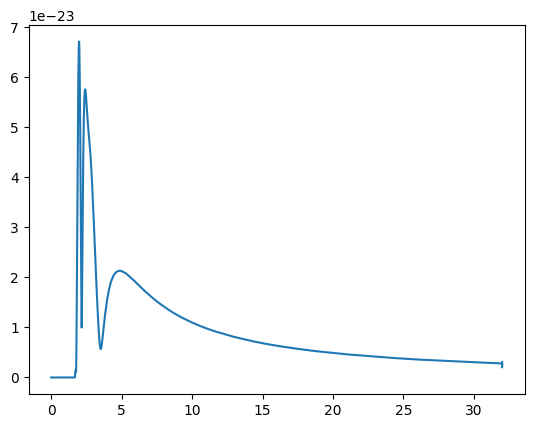

In [3]:
plt.plot(frequencies, np.abs(projected_strain_pycbc_vp_fd))

In [4]:
from gw_utils import fplus_fcross
from waveform import WaveformGenerator

detector_names = ['H']
tgps = 1234567890
tcoarse = 0.01
approximant = 'IMRPhenomD'
harmonic_modes = [(2, 2)]
disable_precession = False
n_cached_waveforms = 1
lalsimulation_commands = ()

wg = WaveformGenerator(detector_names, tgps, tcoarse, approximant,
                                       harmonic_modes=harmonic_modes,
                                       disable_precession=disable_precession,
                                       n_cached_waveforms=n_cached_waveforms,
                                       lalsimulation_commands=lalsimulation_commands)


In [5]:
params_dic = {
    'ra': 0,
    'dec': 0,
    't_geocenter': 1234567890,
    'psi': 0,
    'phi_ref': 0.0,                 # Phase at reference frequency (radians)
    'm1': 1.4,                    # Mass of the first object (in Msun)
    'm2': 1.4,                    # Mass of the second object (in Msun)
    'l1': 0,
    'l2': 0,
    's1x_n': 0.0,                     # Spin component of the first object (x-axis)
    's1y_n': 0.0,                     # Spin component of the first object (y-axis)
    's1z': 0.0,                     # Spin component of the first object (z-axis)
    's2x_n': 0.0,                     # Spin component of the second object (x-axis)
    's2y_n': 0.0,                     # Spin component of the second object (y-axis)
    's2z': 0.0,                     # Spin component of the second object (z-axis)
    'f_ref': 0,                 # Reference frequency (Hz)
    'd_luminosity': 400,            # Luminosity distance (meters)
    'iota': 0.0,                    # Inclination angle (radians)
    'lal_dic': lal.CreateDict(),    # LAL dictionary for additional parameters
}

f = np.linspace(0, 32, 10000)
hp_cogwheel, hc_cogwheel = wg.get_hplus_hcross(f, params_dic, by_m = False)

mask = np.logical_and(f>=2, f <= 31)

In [6]:
%%prun
strain_0 = wg.get_strain_at_detectors(f, params_dic)

         84 function calls in 0.006 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 {built-in method lal._lal.GreenwichMeanSiderealTime}
        3    0.001    0.000    0.001    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.001    0.001    0.001    0.001 {built-in method lal._lal.ComputeDetAMResponse}
        1    0.001    0.001    0.002    0.002 waveform.py:642(_get_shifts)
        2    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.001    0.000    0.001    0.000 numeric.py:2378(array_equal)
        1    0.000    0.000    0.001    0.001 waveform.py:676(get_hplus_hcross)
        1    0.000    0.000    0.001    0.001 gw_utils.py:77(get_geocenter_delays)
        1    0.000    0.000    0.003    0.003 waveform.py:605(get_hplus_hcross_at_detectors)
        1    0.000    0.000    0.006    0.006 {built-in method 

In [17]:
%%prun
strain_1 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization=True, doppler=False, use_cached=True)

         105 function calls in 0.012 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.002    0.002 {built-in method lal._lal.CreateDict}
        1    0.002    0.002    0.002    0.002 {built-in method lalsimulation._lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1}
        1    0.001    0.001    0.001    0.001 {built-in method lalsimulation._lalsimulation.SimInspiralChooseFDWaveformSequence}
        1    0.001    0.001    0.006    0.006 waveform.py:34(compute_hplus_hcross)
        1    0.001    0.001    0.007    0.007 waveform.py:148(<dictcomp>)
        1    0.001    0.001    0.012    0.012 <string>:1(<module>)
        3    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 {built-in method lalsimulation._lalsimulation.SimInspiralModeArrayActivateMode}
        1    0.000    0.000    0.011    0.011 waveform.py:605(g

In [12]:
%%prun
strain_2 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization = True, doppler = True, use_cached=True)

         61 function calls in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <string>:1(<module>)
        3    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1    0.000    0.000    0.001    0.001 waveform.py:676(get_hplus_hcross)
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 numeric.py:2378(array_equal)
        1    0.000    0.000    0.000    0.000 waveform.py:755(_matching_cache)
        1    0.000    0.000    0.000    0.000 linalg.py:2383(norm)
        1    0.000    0.000    0.001    0.001 waveform.py:605(get_hplus_hcross_at_detectors)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 {

In [14]:
%%prun
strain_3 = wg.get_strain_at_detectors(f[mask], params_dic, vary_polarization = False, doppler = True, use_cached=False)

         264601 function calls in 0.449 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.090    0.009    0.090    0.009 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.062    0.031    0.062    0.031 {built-in method lalsimulation._lalsimulation.SimInspiralChooseFDWaveformSequence}
     9062    0.045    0.000    0.068    0.000 _interpolate.py:690(_call_linear)
        2    0.037    0.018    0.109    0.054 waveform.py:34(compute_hplus_hcross)
        1    0.031    0.031    0.445    0.445 waveform.py:813(time_series)
        2    0.021    0.011    0.035    0.018 function_base.py:1663(unwrap)
        2    0.019    0.009    0.019    0.009 function_base.py:1606(angle)
        2    0.015    0.007    0.015    0.007 {built-in method numpy.arange}
        2    0.009    0.005    0.009    0.005 {method 'cumsum' of 'numpy.ndarray' objects}
     9062    0.009    0.000    0.021    0.000 _util.py:275(_asarray_valida

In [10]:
# mask1 = np.logical_and(frequencies >= 2, frequencies <= 31)
# plt.figure(figsize=(10, 6))
# plt.plot(f[mask], abs(strain_1[0]), label='vp_cogwheel', color='blue', linestyle='-', linewidth=1.5)
# plt.plot(frequencies[mask1], abs(projected_strain_pycbc_vp_fd[mask1]), label='vp_pycbc', color='orange', linestyle='--', linewidth=1.5)
# #plt.plot(frequencies, abs(projected_strain_pycbc_const_fd), label='const_pycbc', color='cyan', linestyle=':', linewidth=1.5)
# #plt.plot(f, abs(strain_0[0]), label='const_cogwheel', color='magenta', linestyle='dotted', linewidth=1.5)


# plt.xlabel('Frequency (Hz)', fontsize=14)
# plt.ylabel('Strain Amplitude', fontsize=14)
# plt.title('Comparison of Strain at Detectors', fontsize=16)

# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend()
# plt.savefig('Strain_Signal_Comparison.pdf')
# plt.show()
hp_time_windowed.start_time += geocent_time
hc_time_windowed.start_time += geocent_time


In [11]:


projected_strain_pycbc_lal = detector.project_wave(
    hp_time_windowed, hc_time_windowed, ra, dec, polarization, method='lal')

projected_strain_pycbc_lal_fd = projected_strain_pycbc_lal.to_frequencyseries()

freq_lal = projected_strain_pycbc_lal_fd.get_sample_frequencies()

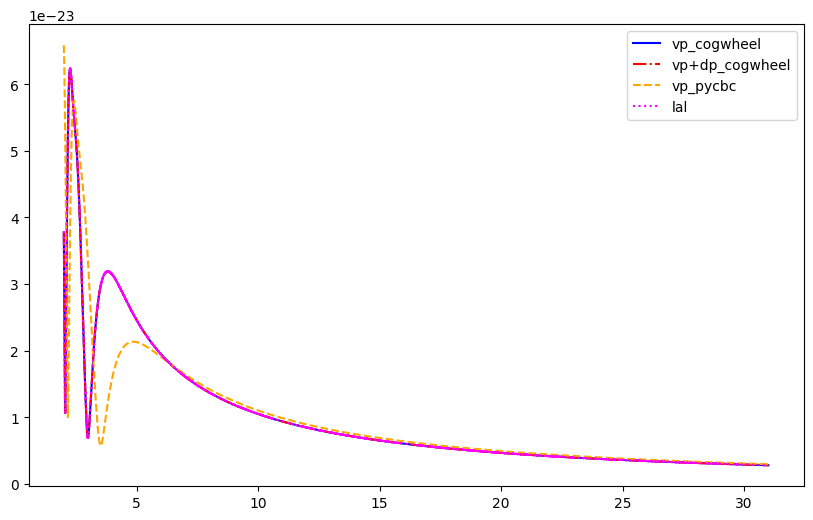

In [12]:
mask1 = np.logical_and(frequencies >= 2, frequencies <= 31)
mask2 = np.logical_and(freq_lal >= 2, freq_lal <= 31)

plt.figure(figsize=(10, 6))
plt.plot(f[mask], abs(strain_1[0]), label='vp_cogwheel', color='blue', linestyle='-', linewidth=1.5)
plt.plot(f[mask], abs(strain_2[0]), label='vp+dp_cogwheel', color='red', linestyle='-.', linewidth=1.5)
plt.plot(frequencies[mask1], abs(projected_strain_pycbc_vp_fd[mask1]), label='vp_pycbc', color='orange', linestyle='--', linewidth=1.5)
plt.plot(freq_lal[mask2], np.abs(projected_strain_pycbc_lal_fd[mask2]), label = 'lal', color = 'magenta', linestyle = 'dotted', linewidth = 1.5)
plt.legend()